# Exploracion de datos 

# Importacion de datos desde API
No requiere credenciales

In [4]:
from typing import Final
import requests
import zipfile
import io
import pandas as pd
import os
import logging
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gdp


warnings.filterwarnings('ignore')

DATA_DIR: Final = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'raw'
)

file_path = os.path.join(DATA_DIR, 'online_retail_II.xlsx')

if not os.path.exists(file_path):
    url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
    response = requests.request("GET", url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall(path=DATA_DIR)
    logging.info("Downloaded and extracted the zip file")

# Load the .xlsx file into a pandas dataframe
year_2009_2010 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
year_2010_2011 = pd.read_excel(file_path, sheet_name='Year 2010-2011')
logging.info("Loaded the data into a pandas dataframe")

df = pd.concat([year_2009_2010, year_2010_2011], ignore_index=True)
df.head(1)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom


Observamos los tipos de datos disponibles

In [5]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [6]:
df.shape

(1067371, 8)

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

# Descripción de las variables

In [8]:
# estadísticas de las columnas categoricas
df.describe( include=['object', 'string'])

,Invoice,StockCode,Description,Country
count,1067371,1067371,1062989,1067371
unique,53628,5305,5698,43
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1350,5829,5918,981330


Podemos ver que en el campo Description tenemos valores nulos a analizar. El país con mayores ventas es United Kingdom, tenemos 40 países. El Invoice es el indicador de factura, en realidad en todo el dataset se realizaron 28816 ventas facturadas. 

In [9]:
df.describe( include=['float64', 'int64'])

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


En la variable Quantity hay valores fuera de serie grandes, los datos se concentran en valores cercanos a 10, por lo que existe un sesgo a la derecha, es decir los valores tienen una asímetría positiva. Por ende, los datos deben ser escalados o aplicados con un logaritmo en caso de aplicar modelos estadísticos con supuestos en distribuciones normales. El precio presenta el mismo problema de asimetría positiva. Para el Customer se debe cambiar de número a objeto ya que nos interesa la cantidad que veces que compró un mismo cliente, no operaciones entre el ID. 

In [10]:
df.describe( include= 'datetime64[ns]')

,InvoiceDate
count,1067371
mean,2011-01-02 21:13:55.394028544
min,2009-12-01 07:45:00
25%,2010-07-09 09:46:00
50%,2010-12-07 15:28:00
75%,2011-07-22 10:23:00
max,2011-12-09 12:50:00


En cuanto al tiempo, el rango o periodo es desde 2009 diciembre hasta 2011 diciembre, abarcando un dos años de ventas online. 

# Analisis de valores faltantes

Lo que realizaremos es un analisis de los valores faltantes para descartar cualquier valor nulo por error de digitación. Para ello, compararemos por StockCode para ver si en el periodo de estudio existe un misdo StockCode con el valor que podría ir en los valores faltantes. 

In [11]:
# Step 1: Filter rows where Description or CustomerID is missing
missing_values_df = df[df['Description'].isna() | df['Customer ID'].isna()]

# Step 2: Group by Stockcode or InvoiceID
grouped_by_stockcode = missing_values_df.groupby('StockCode')

# Stockcode example
inconsistent_stockcode = grouped_by_stockcode.apply(
    lambda x: x[['Description', 'Customer ID']].isna().all(axis=0)
).reset_index()

# Filtering the inconsistent groups where not all values are missing
inconsistent_stockcodes = inconsistent_stockcode[inconsistent_stockcode.any(axis=1)]

In [12]:
# no siempre son valores nulos estos codigos:
inconsistent_stockcodes.loc[inconsistent_stockcodes.Description == False]

,StockCode,Description,Customer ID
0,10002,False,True
1,10080,False,True
3,10120,False,True
4,10125,False,True
5,10133,False,True
...,...,...,...
5170,gift_0001_40,False,True
5171,gift_0001_50,False,True
5173,gift_0001_70,False,True
5174,gift_0001_80,False,True


Como ejemplo, veamos gift_0001_80 de codigo de Stock, este tiene dos valores posibles como vemos a continuación:

In [13]:
df.loc[df['StockCode'] == 'gift_0001_80'].Description.unique() 

array([nan, 'Dotcomgiftshop Gift Voucher £80.00'], dtype=object)

Como vimos, hay valores que tienen dos opciones o hasta 3. Por ahora vamos a cambiar los valores de nan por el valor que se utiliza en la serie:

In [14]:
# Step 1: Group by StockCode and get unique values in Description
unique_values = df.groupby('StockCode')['Description'].unique()

# Step 2: Identify StockCodes with exactly one non-null and one NaN value
stockcodes_to_impute = unique_values[unique_values.apply(lambda x: len(x) == 2 and pd.isna(x).any())]

# Step 3: Create a dictionary for imputation (mapping StockCode to its non-null Description)
imputation_dict = {stockcode: next(val for val in values if pd.notna(val)) 
                   for stockcode, values in stockcodes_to_impute.items()}


Acá vemos una lista de los códgios de Stock y su respectivo valor no nulo

In [15]:
imputation_dict

{10002: 'INFLATABLE POLITICAL GLOBE ',
 10109: 'BENDY COLOUR PENCILS',
 10134: 'COLOURING PENCILS BROWN TUBE',
 10138: 'ASSORTED COLOUR JUMBO PEN',
 15030: 'FAN BLACK FRAME ',
 15036: 'ASSORTED COLOURS SILK FAN',
 16010: 'FOLDING CAMPING SCISSOR W/KNIF & S',
 16015: 'MEDIUM CHINESE STYLE SCISSOR',
 16033: 'MINI HIGHLIGHTER PENS',
 16043: 'POP ART PUSH DOWN RUBBER ',
 16044: 'POP-ART FLUORESCENT PENS',
 16046: 'TEATIME PEN CASE & PENS',
 16047: 'POP ART PEN CASE & PENS',
 16049: 'TEATIME GEL PENS ASST',
 16050: 'TEATIME PENCIL WITH RUBBER',
 16051: 'TEATIME PENCIL W STAMP ASST',
 16052: 'TEATIME PUSH DOWN RUBBER',
 16053: 'POPART COL BALLPOINT PEN ASST',
 16119: 'FUNKY GIRL ADDRESS BOOK',
 16192: 'PINK BALLET OPENING CUBE BOX ',
 16212: 'FUNKY GIRLZ ASST MAGNETIC MEMO PAD',
 16215: 'FUNKY GIRLZ MAGNETIC TO DO LIST ',
 16239: 'BALLERINA HEART DECORATION.',
 16254: 'TRANSPARENT ACRYLIC TAPE DISPENSER',
 16259: 'PIECE OF CAMO STATIONERY SET',
 17001: 'HEAVENS SCENT FRAGRANCE OILS ASSTD',
 

Vamos a proceder a remplazar los valores nulos cuando al descripción es un valor nulo y su codigo está en el diccionario que creamos:

In [16]:
# Step 4: Apply the imputation only for the same StockCode
df['Description'] = df.apply(
    lambda row: imputation_dict[row['StockCode']] 
    if pd.isna(row['Description']) and row['StockCode'] in imputation_dict else row['Description'], axis=1
)

Veamos el mismo ejemplo de antes:

In [17]:
df.loc[df['StockCode'] == 'gift_0001_80'].Description.unique() 

array(['Dotcomgiftshop Gift Voucher £80.00'], dtype=object)

Procedemos a ver los valores nulos nuevamente:

In [18]:
df.isna().sum()

Invoice             0
StockCode           0
Description      1320
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

reducimos los valores nulos de Description de 4382 a 1320 una reducción del 70% aproximadamente con este enfoque.
Ahora veamos los valores faltantes y detectemos cuando estos valores son solamente nulos:

# Valores que siempre son nulos en el código de stock

In [19]:
# Step 1: Filter rows where Description or CustomerID is missing
missing_values_df = df[df['Description'].isna() | df['Customer ID'].isna()]

# Step 2: Group by Stockcode or InvoiceID
grouped_by_stockcode = missing_values_df.groupby('StockCode')

# Stockcode example
inconsistent_stockcode = grouped_by_stockcode.apply(
    lambda x: x[['Description', 'Customer ID']].isna().all(axis=0)
).reset_index()

# Filtering the inconsistent groups where not all values are missing
inconsistent_stockcodes = inconsistent_stockcode[inconsistent_stockcode.any(axis=1)]



In [20]:
# siempre son valores nulos estos codigos:
inconsistent_stockcodes.loc[inconsistent_stockcodes.Description == True]

,StockCode,Description,Customer ID
35,16131,True,True
36,16132,True,True
38,16195,True,True
39,16210,True,True
51,16240,True,True
...,...,...,...
5156,DCGSLBOY,True,True
5157,DCGSLGIRL,True,True
5161,GIFT,True,True
5172,gift_0001_60,True,True


In [21]:
df.loc[df['StockCode'] == 'gift_0001_60'].Description.unique() 

array([nan], dtype=object)

Como vemos, tenemos 361 casos en donde el valor de Descripcion siempre es nulo. Ahora para analizar como la eliminación de estos valores afectaría un modelo predictivo: 

In [22]:
# agrupamos por StockCode
grouped_by_stockcode = df.groupby('StockCode')
stockcodes_with_nan = grouped_by_stockcode.apply(lambda x: x['Description'].isna().all())
stockcodes_with_nan = stockcodes_with_nan[stockcodes_with_nan].index.tolist()

In [23]:
stockcodes_with_nan
# un vistazo de los StockCode que siempre son nulos en descripcion

[16131,
 16132,
 16195,
 16210,
 16240,
 16255,
 17017,
 17120,
 17160,
 18033,
 20690,
 20691,
 20710,
 20720,
 20743,
 20824,
 20844,
 20859,
 20880,
 20883,
 20900,
 20904,
 20911,
 20937,
 20938,
 20944,
 20946,
 20951,
 20955,
 20959,
 20965,
 20995,
 21005,
 21019,
 21020,
 21021,
 21022,
 21023,
 21024,
 21029,
 21047,
 21048,
 21052,
 21057,
 21083,
 21104,
 21113,
 21148,
 21170,
 21176,
 21177,
 21182,
 21183,
 21227,
 21236,
 21273,
 21295,
 21301,
 21325,
 21342,
 21345,
 21362,
 21487,
 21492,
 21502,
 21505,
 21510,
 21512,
 21514,
 21583,
 21601,
 21602,
 21646,
 21753,
 21776,
 21778,
 21835,
 21855,
 21859,
 21862,
 21863,
 21909,
 21920,
 22022,
 22213,
 35232,
 35442,
 35473,
 35763,
 35794,
 35839,
 35900,
 35925,
 35926,
 35935,
 35940,
 35941,
 35948,
 35949,
 35960,
 35983,
 35990,
 35992,
 35993,
 35994,
 37350,
 37353,
 37504,
 44276,
 47009,
 47361,
 47559,
 47565,
 48169,
 48172,
 71265,
 71431,
 72234,
 72483,
 72719,
 72748,
 72768,
 72777,
 72778,
 72806,


Podemos ver un resumen estadistico de los valores que siempre son nulos en StockCode:

In [24]:
df.loc[df['StockCode'].isin(stockcodes_with_nan)].describe(include=['int64', 'float64'])

,Quantity,Price,Customer ID
count,363.000000,363.0,0.0
mean,-44.201102,0.0,NaN
std,327.616760,0.0,NaN
min,-4999.000000,0.0,NaN
25%,-23.000000,0.0,NaN
50%,-7.000000,0.0,NaN
75%,-1.000000,0.0,NaN
max,160.000000,0.0,NaN


Con esto vemos que también son siempre nulos los valores de Customer ID, el precio es 0 siempre y las cantidades son negativas o con un maximo de 160 cantidades, concentrandoce en -44 los datos, pero tenemos una asímetría positiva en los datos, es decir hay valores muy negativos que afectan el calculo llegando hasta -5000 aproximadamente. 


Por lo anterior, podemos eliminar los valores nulos, abajo dejo una grafica donde muestro que con esto se afecta únicamente los valores de reino unido. 

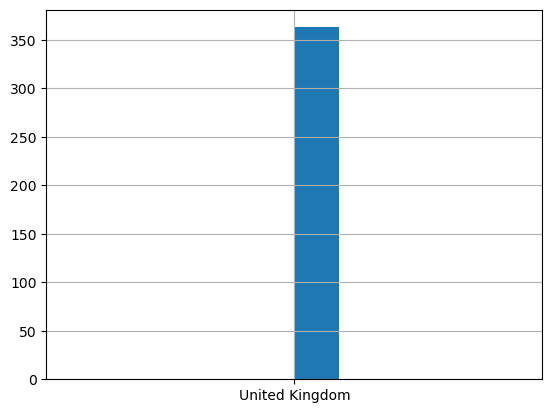

In [25]:
df.loc[df['StockCode'].isin(stockcodes_with_nan)]['Country'].hist()
plt.show()

procedemos a eliminar los valores nulos del dataframe y lo renombramos

In [26]:
df = df[~df['StockCode'].isin(stockcodes_with_nan)]

In [27]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067008e+06,1067008,1.067008e+06,824364.000000
mean,9.957317e+00,2011-01-02 23:50:41.346493696,4.650969e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 11:44:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:52:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.726268e+02,NaN,1.235740e+02,1697.464450


# remplazo de valores nulos en descripción segun multiples opciones en Stock Code

Vamos a remplazar los demás valores para facilitar los calculos en los demás casos:

In [28]:
# Step 1: Group by StockCode and get unique values in Description
unique_values = df.groupby('StockCode')['Description'].unique()

# Step 2: Identify StockCodes with exactly one non-null and one NaN value
stockcodes_to_impute = unique_values[unique_values.apply(lambda x: len(x) >= 2)]

# Step 3: Create a dictionary for imputation (mapping StockCode to its non-null Description)
imputation_dict = {stockcode: values.tolist() for stockcode, values in stockcodes_to_impute.items() if pd.notna(stockcode)}


Vemos abajo que los valores que remplazan a nan pueden ser una palabra con letras capitales o minuscula

In [29]:
imputation_dict

{10080: ['GROOVY CACTUS INFLATABLE', nan, 'check'],
 10120: ['DOGGY RUBBER', 'Zebra invcing error'],
 10133: ['COLOURING PENCILS BROWN TUBE', 'damaged'],
 16008: ['SMALL FOLDING SCISSOR(POINTED EDGE)', 'check'],
 16011: [' ANIMAL STICKERS', 'ANIMAL STICKERS'],
 16012: ['FOOD/DRINK SPUNGE STICKERS', 'FOOD/DRINK SPONGE STICKERS'],
 16045: ['POPART WOODEN PENCILS ASST', nan, 'check'],
 16235: ['RECYCLED PENCIL WITH RABBIT ERASER', '?'],
 17033: ['BROCADE PURSE,SMALL ARCH BUTTON',
  'sold as 17003?',
  'Sold as 17003?',
  nan],
 20615: ['BLUE SPOTTY PASSPORT COVER', 'BLUE POLKADOT PASSPORT COVER'],
 20622: ['VIPPASSPORT COVER ', 'VIP PASSPORT COVER '],
 20652: ['BLUE SPOTTY LUGGAGE TAG ',
  nan,
  'BLUE POLKADOT LUGGAGE TAG ',
  'check'],
 20658: ['RED SPOTTY LUGGAGE TAG', 'RED RETROSPOT LUGGAGE TAG', nan],
 20661: ['BLUE SPOTTY PURSE ', 'BLUE POLKADOT PURSE '],
 20665: ['RED SPOTTY PURSE ',
  'RED RETROSPOT PURSE ',
  nan,
  'dotcom',
  'adjustment'],
 20674: ['GREEN SPOTTY BOWL', 'GREEN 

Un ejemplo de los casos que tienen más de un caso para remplazar: 

In [30]:
df.loc[df['StockCode'] == 10080].Description.unique()

array(['GROOVY CACTUS INFLATABLE', nan, 'check'], dtype=object)

generamos una función para encontrar los valores que son letra pequeña como  'check'

In [31]:
def find_unique_lowercase_values(d):
    unique_values = set()
    for lst in d.values():
        for item in lst:
            if isinstance(item, str) and item.islower():
                unique_values.add(item)
    return list(unique_values)

In [32]:
lowercase_dict = find_unique_lowercase_values(imputation_dict)
len(lowercase_dict)
lowercase_dict


['lost in space',
 'reverse 21/5/10 adjustment',
 'damaged/dirty',
 'dotcom email',
 'adjust',
 'damages/showroom etc',
 'check',
 'damages?',
 'crushed boxes',
 'wrongly marked carton 22804',
 'broken',
 'crushed',
 'sold as set on dotcom and amazon',
 'wrong code?',
 'missing',
 'missings',
 'broken, uneven bottom',
 "can't find",
 'temp',
 '85123a mixed',
 'found some more on shelf',
 'taig adjust no stock',
 'sold as set/6 by dotcom',
 'cant find',
 'bad quality',
 'damaged?',
 'temp adjustment',
 'code mix up? 84930',
 'sold as set/6 on dotcom',
 'dotcomstock',
 'sold in set?',
 'water damaged',
 'display',
 'returned',
 'wet rusty',
 '? sold as sets?',
 'wet',
 'wrong invc',
 '?lost',
 'amazon adjustment',
 'rusty throw away',
 'wrong code',
 'wrong barcode',
 'show display',
 'barcode problem',
 'checked',
 '?? missing',
 'sold as 22467',
 'for show',
 'wrong ctn size',
 'damages/display',
 'on cargo order',
 'lost?',
 'dotcom adjust',
 'historic computer difference?....se',
 'f

de estos valores de letra pequeña, existen codigos que eran los que realmente iban a marcas

In [33]:
import re
numeric_values = [value for value in lowercase_dict if re.findall(r'\D*(\d+)\D*', value)]
numeric_values

['reverse 21/5/10 adjustment',
 'wrongly marked carton 22804',
 '85123a mixed',
 'sold as set/6 by dotcom',
 'code mix up? 84930',
 'sold as set/6 on dotcom',
 'sold as 22467',
 '21733 mixed',
 'invcd as 84879?',
 'sold as 17003?',
 'wrongly coded 23343',
 'wrongly marked. 23343 in box',
 'wrongly coded-23343',
 '17129c',
 'sold as 1',
 'wrongly marked 23343',
 'came coded as 20713',
 'code mix up 72597',
 'wrongly coded 20713',
 'wrongly sold (22719) barcode',
 'invoice 506647',
 '20713 wrongly marked',
 'wrong barcode (22467)']

Estos son los posibles errores en operación solucionables desde la data, por ende podemos remplazar el stock code con valoes que si eran. Esto debido a que el sistema no deja cambiar, probablemente por la facturación 

In [34]:
# TODO: Impute the missing values for the StockCode
result_dict = {}
# Loop through each item in the list
for text in numeric_values:
    # Find all numbers in the text
    numbers = re.findall(r'\D*(\d+)\D*', text)
    if len(str(numbers)) > 0:
        # Use the first number as the key (assuming only one number per string)
        key = int(numbers[0])
        # Store the entire text as the value
        result_dict[text] = key

result_dict

{'reverse 21/5/10 adjustment': 21,
 'wrongly marked carton 22804': 22804,
 '85123a mixed': 85123,
 'sold as set/6 by dotcom': 6,
 'code mix up? 84930': 84930,
 'sold as set/6 on dotcom': 6,
 'sold as 22467': 22467,
 '21733 mixed': 21733,
 'invcd as 84879?': 84879,
 'sold as 17003?': 17003,
 'wrongly coded 23343': 23343,
 'wrongly marked. 23343 in box': 23343,
 'wrongly coded-23343': 23343,
 '17129c': 17129,
 'sold as 1': 1,
 'wrongly marked 23343': 23343,
 'came coded as 20713': 20713,
 'code mix up 72597': 72597,
 'wrongly coded 20713': 20713,
 'wrongly sold (22719) barcode': 22719,
 'invoice 506647': 506647,
 '20713 wrongly marked': 20713,
 'wrong barcode (22467)': 22467}

comparamos antes:

In [35]:
df_test = df.copy()

In [36]:
df.loc[df['Description'].str.contains('wrongly marked.', na=False)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
789345,560039,20713,wrongly marked. 23343 in box,-3100,2011-07-14 14:27:00,0.0,NaN,United Kingdom
941043,572547,20713,wrongly marked 23343,200,2011-10-24 17:01:00,0.0,NaN,United Kingdom
982292,575722,85123A,wrongly marked carton 22804,-256,2011-11-10 18:20:00,0.0,NaN,United Kingdom


In [37]:

df_test['StockCode'] = df_test.apply(
    lambda row: result_dict[row['Description']] 
    if row['Description'] in result_dict else row['StockCode'], axis=1
)

comparamos despues:

In [38]:
df_test.loc[df_test['Description'].str.contains('wrongly marked.', na=False)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
789345,560039,23343,wrongly marked. 23343 in box,-3100,2011-07-14 14:27:00,0.0,NaN,United Kingdom
941043,572547,23343,wrongly marked 23343,200,2011-10-24 17:01:00,0.0,NaN,United Kingdom
982292,575722,22804,wrongly marked carton 22804,-256,2011-11-10 18:20:00,0.0,NaN,United Kingdom


# cambio de palabras en minúscula por el item correcto en Descripción

Otra función para detectar las palabras de descripción con valores en mayúscula

In [39]:
def find_uppercase_in_dict(d):
    result = {}
    for key, lst in d.items():
        lowercase_elements = [item for item in lst if isinstance(item, str) and item.isupper()]
        if lowercase_elements:
            result[key] = lowercase_elements
    return result

# Get dictionary with only lowercase elements
upper_case = find_uppercase_in_dict(imputation_dict)
upper_case

{10080: ['GROOVY CACTUS INFLATABLE'],
 10120: ['DOGGY RUBBER'],
 10133: ['COLOURING PENCILS BROWN TUBE'],
 16008: ['SMALL FOLDING SCISSOR(POINTED EDGE)'],
 16011: [' ANIMAL STICKERS', 'ANIMAL STICKERS'],
 16012: ['FOOD/DRINK SPUNGE STICKERS', 'FOOD/DRINK SPONGE STICKERS'],
 16045: ['POPART WOODEN PENCILS ASST'],
 16235: ['RECYCLED PENCIL WITH RABBIT ERASER'],
 17033: ['BROCADE PURSE,SMALL ARCH BUTTON'],
 20615: ['BLUE SPOTTY PASSPORT COVER', 'BLUE POLKADOT PASSPORT COVER'],
 20622: ['VIPPASSPORT COVER ', 'VIP PASSPORT COVER '],
 20652: ['BLUE SPOTTY LUGGAGE TAG ', 'BLUE POLKADOT LUGGAGE TAG '],
 20658: ['RED SPOTTY LUGGAGE TAG', 'RED RETROSPOT LUGGAGE TAG'],
 20661: ['BLUE SPOTTY PURSE ', 'BLUE POLKADOT PURSE '],
 20665: ['RED SPOTTY PURSE ', 'RED RETROSPOT PURSE '],
 20674: ['GREEN SPOTTY BOWL', 'GREEN POLKADOT BOWL'],
 20675: ['BLUE SPOTTY BOWL', 'BLUE POLKADOT BOWL'],
 20676: ['RED SPOTTY BOWL', 'RED RETROSPOT BOWL'],
 20677: ['PINK SPOTTY BOWL', 'PINK POLKADOT BOWL'],
 20679: ['EDW

In [40]:
df.loc[df['StockCode'] == 10080].groupby('Description').agg({'InvoiceDate': max}).sort_values(by='InvoiceDate', ascending=False)

,InvoiceDate
Description,
GROOVY CACTUS INFLATABLE,2011-11-21 17:04:00
check,2011-11-10 10:53:00


Para este ejercicio vamos a quedarnos solo con los valores que tienen una sola posibilidad en letra mayúscula

In [41]:
upper_case_single = {key: value[0] for key, value in upper_case.items() if len(value) == 1}
upper_case_single

{10080: 'GROOVY CACTUS INFLATABLE',
 10120: 'DOGGY RUBBER',
 10133: 'COLOURING PENCILS BROWN TUBE',
 16008: 'SMALL FOLDING SCISSOR(POINTED EDGE)',
 16045: 'POPART WOODEN PENCILS ASST',
 16235: 'RECYCLED PENCIL WITH RABBIT ERASER',
 17033: 'BROCADE PURSE,SMALL ARCH BUTTON',
 20679: 'EDWARDIAN PARASOL RED',
 20692: 'FLORAL ELEPHANT SOFT TOY',
 20694: 'FLORAL PINK MONSTER',
 20700: 'GREEN CAT FLORAL CUSHION COVER ',
 20711: 'JUMBO BAG TOYS ',
 20712: 'JUMBO BAG WOODLAND ANIMALS',
 20713: 'JUMBO BAG OWLS',
 20714: 'POSY SHOPPER BAG',
 20738: 'GREEN MINI TAPE MEASURE ',
 20748: 'KENSINGTON COFFEE SET',
 20751: 'FUNKY WASHING UP GLOVES ASSORTED',
 20774: 'GREEN FERN NOTEBOOK',
 20786: 'BLACK RETRO BAR STOOL',
 20787: 'BLUE RETRO BAR STOOL',
 20798: 'CLEAR MILKSHAKE GLASS',
 20799: 'PINK MILKSHAKE GLASS',
 20803: 'SMALL PINK GLASS SUNDAE DISH',
 20820: 'SILVER LOOKING MIRROR',
 20821: 'GOLDIE LOOKING MIRROR',
 20825: 'GOLD WINE GLASS',
 20827: 'GOLD APERITIF GLASS',
 20830: 'SILVER PHOTO FRAM

In [42]:
# Step 4: Apply the imputation only for the same StockCode

df['Description'] = df['Description'].astype(str) 
df['Description'] = df.apply(
    lambda row: upper_case_single[row['StockCode']] 
    if row['StockCode'] in upper_case_single else row['Description'], axis=1
)

In [43]:
df.loc[df['StockCode'] == 10080].groupby('Description').agg({'InvoiceDate': max}).sort_values(by='InvoiceDate', ascending=False)

,InvoiceDate
Description,
GROOVY CACTUS INFLATABLE,2011-11-21 17:04:00


In [44]:
df.isna().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    242644
Country             0
dtype: int64

Con esto explicamos el 100% de los valores nulos en Description. En los casos donde se tiene una variable en mayúscula y otra en minuscula, se quedó con la variable en mayúscula. Hay casos donde hay más de una descripción para la variable, estos no nos interesa por el momento

# Analisis de valores nulos en customer ID 

In [45]:
# analisis de valores nulos en customer ID
df_customer_id = df.loc[df['Customer ID'].isna()]
df_customer_id.Description.count()

242644

In [46]:
df_customer_id.describe(include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
count,242644.0,242644,242644,242644.000000,242644,242644.000000,0.0,242644
unique,8389.0,4822,5085,NaN,NaN,NaN,NaN,15
top,537434.0,DOT,DOTCOM POSTAGE,NaN,NaN,NaN,NaN,United Kingdom
freq,1350.0,1430,1430,NaN,NaN,NaN,NaN,239666
mean,NaN,NaN,NaN,1.608979,2011-01-06 13:58:55.255023872,7.960635,NaN,NaN
min,NaN,NaN,NaN,-9600.000000,2009-12-01 10:52:00,-53594.360000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2010-07-23 15:09:00,1.660000,NaN,NaN
50%,NaN,NaN,NaN,1.000000,2010-12-20 16:08:00,3.290000,NaN,NaN
75%,NaN,NaN,NaN,2.000000,2011-07-12 16:11:00,5.790000,NaN,NaN
max,NaN,NaN,NaN,10200.000000,2011-12-09 10:26:00,25111.090000,NaN,NaN


0.22740598008637236

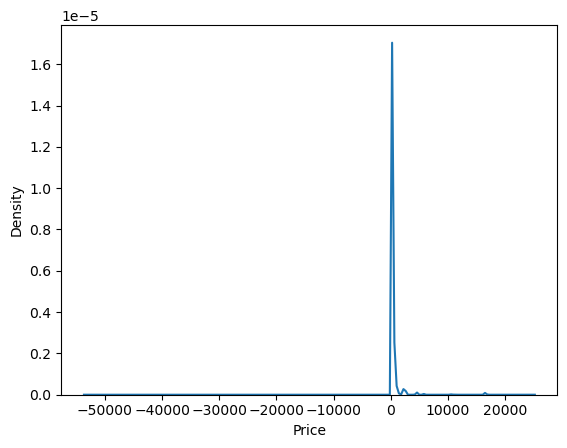

In [47]:

df_customer_id['Description'].value_counts()
df_customer_id.Price.describe()
import seaborn as sns
sns.kdeplot(df_customer_id.Price)
df_customer_id.shape[0] / df.shape[0]
# quitar los valores nulos en Customer ID es dejarnos con menos del 22% de la data

In [48]:
# TODO: concluir en que hacer con los valores nulos en Customer ID

## Ingeneria de Caracteristicas


In [49]:
# Extraer el año
df['Year'] = df['InvoiceDate'].dt.year
# Extraer el mes
df['Month'] = df['InvoiceDate'].dt.month
# Extraer el día
df['Day'] = df['InvoiceDate'].dt.day
# Extraer Hora
df['Hour'] = pd.to_datetime(df['InvoiceDate']).dt.hour
# Extraer dia de la Semana
df['DayOfWeek'] = pd.to_datetime(df['InvoiceDate']).dt.dayofweek
# Extraer si es fecha fin de semana
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
# Colummna Ganacia
df["Ganacia"]= df["Price"]*df["Quantity"]

# Extraer estacionalidad  

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Frecuencia de compras del Cliente

df['PurchaseFrequency'] = df.groupby('Customer ID')['Invoice'].transform('count')

# Valor total del Cliente

df['CustomerLifetimeValue'] = df.groupby('Customer ID')['Ganacia'].transform('sum')

# Total de productos comprados

df['TotalQuantity'] = df.groupby('Invoice')['Quantity'].transform('sum')

# Precio Promedio de transaccion 
df['AvgPricePerTransaction'] = df.groupby('Invoice')['Price'].transform('mean')

# Identificación de transacciones atípicas
df['IsAnomalous'] = (df['Quantity'] > df['Quantity'].quantile(0.99)) | (df['Price'] > df['Price'].quantile(0.99))

# Valor total de la factura
df['TotalInvoiceValue'] = df['Quantity'] * df['Price']

# Ganancia total por cliente y mes
df['CustomerMonthlyGain'] = df.groupby(['Customer ID', 'Year', 'Month'])['Ganacia'].transform('sum')


# Nuevas características agregadas al DataFrame para análisis de ventas y clientes:

# 1. Descomposición de la fecha de factura:
# - 'Year': Año de la transacción.
# - 'Month': Mes de la transacción.
# - 'Day': Día de la transacción.
# - 'Hour': Hora de la transacción.
# - 'DayOfWeek': Día de la semana (0 = Lunes, 6 = Domingo).
# - 'IsWeekend': Indicador booleano que identifica si la transacción ocurrió en fin de semana (Sábado o Domingo).

# 2. Cálculo de métricas financieras:
# - 'Ganacia': Ingreso generado por cada línea de factura (Price * Quantity).
# - 'CustomerLifetimeValue': Valor total generado por cada cliente a lo largo del tiempo.
# - 'TotalInvoiceValue': Valor total de cada factura.

# 3. Análisis estacional:
# - 'Season': Estación del año (Invierno, Primavera, Verano, Otoño) asignada a cada transacción en función del mes.

# 4. Métricas de comportamiento del cliente:
# - 'PurchaseFrequency': Frecuencia de compras del cliente, medida por el número de facturas asociadas.
# - 'CustomerMonthlyGain': Ganancia total generada por cada cliente en un mes específico.

# 5. Métricas de transacción:
# - 'TotalQuantity': Total de productos comprados en cada factura.
# - 'AvgPricePerTransaction': Precio promedio por transacción.
# - 'IsAnomalous': Identificación de transacciones atípicas, donde la cantidad o el precio exceden el percentil 99.

# Estas características adicionales mejoran la capacidad de análisis sobre patrones de compra,
# estacionalidad, valor del cliente y la detección de transacciones inusuales.

In [50]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,...,IsWeekend,Ganacia,Season,PurchaseFrequency,CustomerLifetimeValue,TotalQuantity,AvgPricePerTransaction,IsAnomalous,TotalInvoiceValue,CustomerMonthlyGain
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,...,False,83.4,Winter,92.0,1459.46,166,4.08125,False,83.4,1096.8
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,False,81.0,Winter,92.0,1459.46,166,4.08125,False,81.0,1096.8
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,False,81.0,Winter,92.0,1459.46,166,4.08125,False,81.0,1096.8
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,...,False,100.8,Winter,92.0,1459.46,166,4.08125,False,100.8,1096.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,...,False,30.0,Winter,92.0,1459.46,166,4.08125,False,30.0,1096.8


In [51]:
df.shape
print(f"El nuevo dataframe luego de la implementacion de extraccion y enriquecimiento de caractersticas tiene las dimensiones {df.shape}")

El nuevo dataframe luego de la implementacion de extraccion y enriquecimiento de caractersticas tiene las dimensiones (1067008, 23)


In [52]:
df.columns
print(f"El nuevo dataframe luego de la implementacion de extraccion y enriquecimiento de caractersticas tienes las columnas {df.columns}")

El nuevo dataframe luego de la implementacion de extraccion y enriquecimiento de caractersticas tienes las columnas Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Year', 'Month', 'Day', 'Hour',
       'DayOfWeek', 'IsWeekend', 'Ganacia', 'Season', 'PurchaseFrequency',
       'CustomerLifetimeValue', 'TotalQuantity', 'AvgPricePerTransaction',
       'IsAnomalous', 'TotalInvoiceValue', 'CustomerMonthlyGain'],
      dtype='object')


In [53]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,Year,Month,Day,Hour,DayOfWeek,Ganacia,PurchaseFrequency,CustomerLifetimeValue,TotalQuantity,AvgPricePerTransaction,TotalInvoiceValue,CustomerMonthlyGain
count,1.067008e+06,1067008,1.067008e+06,824364.000000,1.067008e+06,1.067008e+06,1.067008e+06,1.067008e+06,1.067008e+06,1.067008e+06,824364.000000,824364.000000,1.067008e+06,1.067008e+06,1.067008e+06,824364.000000
mean,9.957317e+00,2011-01-02 23:50:41.346493696,4.650969e+00,15324.638504,2.010426e+03,7.498006e+00,1.513542e+01,1.303347e+01,2.463063e+00,1.807601e+01,1071.122215,20132.988178,5.114944e+02,4.650969e+00,1.807601e+01,1572.132246
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,2.009000e+03,1.000000e+00,1.000000e+00,6.000000e+00,0.000000e+00,-1.684696e+05,1.000000,-25111.090000,-8.716700e+04,-5.359436e+04,-1.684696e+05,-25111.090000
25%,1.000000e+00,2010-07-09 11:44:00,1.250000e+00,13975.000000,2.010000e+03,5.000000e+00,8.000000e+00,1.100000e+01,1.000000e+00,3.750000e+00,147.000000,1746.640000,1.410000e+02,2.269630e+00,3.750000e+00,322.650000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000,2.010000e+03,8.000000e+00,1.500000e+01,1.300000e+01,2.000000e+00,9.900000e+00,353.000000,4459.830000,2.820000e+02,3.078882e+00,9.900000e+00,585.550000
75%,1.000000e+01,2011-07-22 10:52:00,4.150000e+00,16797.000000,2.011000e+03,1.100000e+01,2.200000e+01,1.500000e+01,4.000000e+00,1.770000e+01,814.000000,11143.990000,5.270000e+02,4.743250e+00,1.770000e+01,1130.740000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,2.011000e+03,1.200000e+01,3.100000e+01,2.100000e+01,6.000000e+00,1.684696e+05,13097.000000,598215.220000,8.716700e+04,3.897000e+04,1.684696e+05,70246.500000
std,1.726268e+02,NaN,1.235740e+02,1697.464450,5.737146e-01,3.525664e+00,8.680376e+00,2.435354e+00,1.880605e+00,2.924698e+02,2311.218994,59042.779410,1.450802e+03,1.226769e+02,2.924698e+02,3816.375857


Consultas Inciales

In [54]:
ventas_por_año = df.groupby('Year').agg({'Price': 'sum'}).reset_index()
print(ventas_por_año)

   Year        Price
0  2009   198307.760
1  2010  2526012.744
2  2011  2238301.124


In [55]:
ventas_por_mes = df.groupby('Month').agg({'Price': 'sum'}).reset_index()
print(ventas_por_mes)

    Month       Price
0       1  338424.162
1       2  244223.306
2       3  439790.751
3       4  249873.333
4       5  333570.990
5       6  435587.030
6       7  272557.691
7       8  308163.770
8       9  422998.433
9      10  529407.430
10     11  629063.712
11     12  758961.020


In [56]:
ventas_por_dia = df.groupby('Day').agg({'Price': 'sum'}).reset_index()
print(ventas_por_dia)

    Day       Price
0     1  148291.711
1     2  138197.280
2     3  152855.801
3     4  149368.420
4     5  265165.910
5     6  146607.230
6     7  346907.680
7     8  209946.441
8     9  151226.290
9    10  193751.530
10   11  161696.550
11   12   96848.561
12   13  143759.890
13   14  146661.580
14   15  206827.283
15   16  167186.801
16   17  221034.611
17   18  179361.090
18   19  138422.701
19   20  102429.850
20   21  159425.431
21   22  150869.510
22   23  174065.240
23   24  159663.551
24   25  136464.581
25   26  129206.763
26   27  163224.450
27   28  136842.720
28   29   87725.532
29   30  111526.570
30   31   87060.070


In [57]:
ventas_por_dia_semana = df.groupby('DayOfWeek').agg({'Price': 'sum'}).reset_index()
print(ventas_por_dia_semana)

   DayOfWeek        Price
0          0   931016.766
1          1  1097354.502
2          2   779365.123
3          3   929069.962
4          4   813678.953
5          5     1443.260
6          6   410693.062


In [58]:
ventas_por_hora = df.groupby('Hour').agg({'Price': 'sum'}).reset_index()
print(ventas_por_hora)

    Hour       Price
0      6     440.660
1      7    3828.300
2      8   55341.780
3      9  358584.641
4     10  407131.343
5     11  567962.793
6     12  602717.961
7     13  554857.864
8     14  608485.101
9     15  909489.982
10    16  508190.301
11    17  271605.642
12    18   78466.790
13    19   29839.310
14    20    5674.210
15    21       4.950


In [59]:
ventas_por_season = df.groupby('Season').agg({'Price': 'sum'}).reset_index()
print(ventas_por_season)

   Season        Price
0    Fall  1581469.575
1  Spring  1023235.074
2  Summer  1016308.491
3  Winter  1341608.488


In [60]:
ingresos_por_pais = df.groupby('Country').agg({'Ganacia': 'sum'}).reset_index()
ingresos_por_pais = ingresos_por_pais.sort_values(by='Ganacia', ascending=False).reset_index(drop=True)
print(ingresos_por_pais)

                 Country       Ganacia
0         United Kingdom  1.638258e+07
1                   EIRE  6.155196e+05
2            Netherlands  5.485249e+05
3                Germany  4.179886e+05
4                 France  3.281918e+05
5              Australia  1.671291e+05
6            Switzerland  9.972876e+04
7                  Spain  9.185948e+04
8                 Sweden  8.780942e+04
9                Denmark  6.574109e+04
10               Belgium  6.357449e+04
11              Portugal  5.313680e+04
12                 Japan  4.377658e+04
13       Channel Islands  4.145361e+04
14                Norway  3.924303e+04
15                 Italy  3.067935e+04
16               Finland  2.951445e+04
17                Cyprus  2.416274e+04
18               Austria  2.317760e+04
19                Greece  1.899549e+04
20             Hong Kong  1.403930e+04
21             Singapore  1.315816e+04
22                Israel  1.110722e+04
23                Poland  1.052809e+04
24  United Arab Emirates 

In [61]:
ingresos_por_producto = df.groupby('Description').agg({'Ganacia': 'sum'}).reset_index()
ingresos_por_producto = ingresos_por_producto.sort_values(by='Ganacia', ascending=False).reset_index(drop=True)
print(ingresos_por_producto)

                             Description     Ganacia
0               REGENCY CAKESTAND 3 TIER  327813.650
1                         DOTCOM POSTAGE  322647.470
2     WHITE HANGING HEART T-LIGHT HOLDER  257533.900
3                JUMBO BAG RED RETROSPOT  148800.640
4                          PARTY BUNTING  147948.500
...                                  ...         ...
5502                            Discount  -13484.540
5503                        Bank Charges  -33493.669
5504                              Manual  -82781.270
5505                     Adjust bad debt -147614.080
5506                          AMAZON FEE -260763.580

[5507 rows x 2 columns]


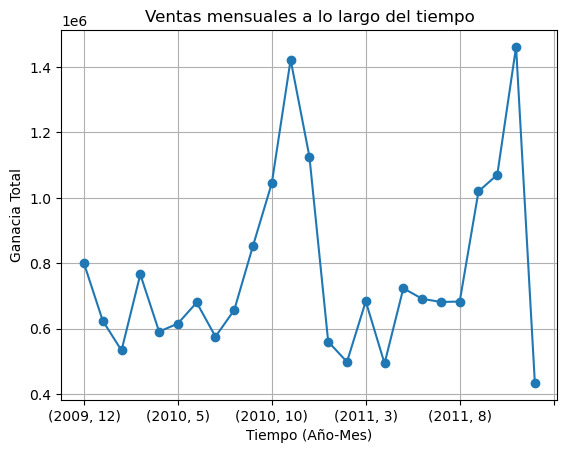

In [62]:
# Crear un gráfico de ventas mensuales
df.groupby(['Year', 'Month'])['Ganacia'].sum().plot(kind='line', marker='o')
plt.title('Ventas mensuales a lo largo del tiempo')
plt.xlabel('Tiempo (Año-Mes)')
plt.ylabel('Ganacia Total')
plt.grid(True)
plt.show()

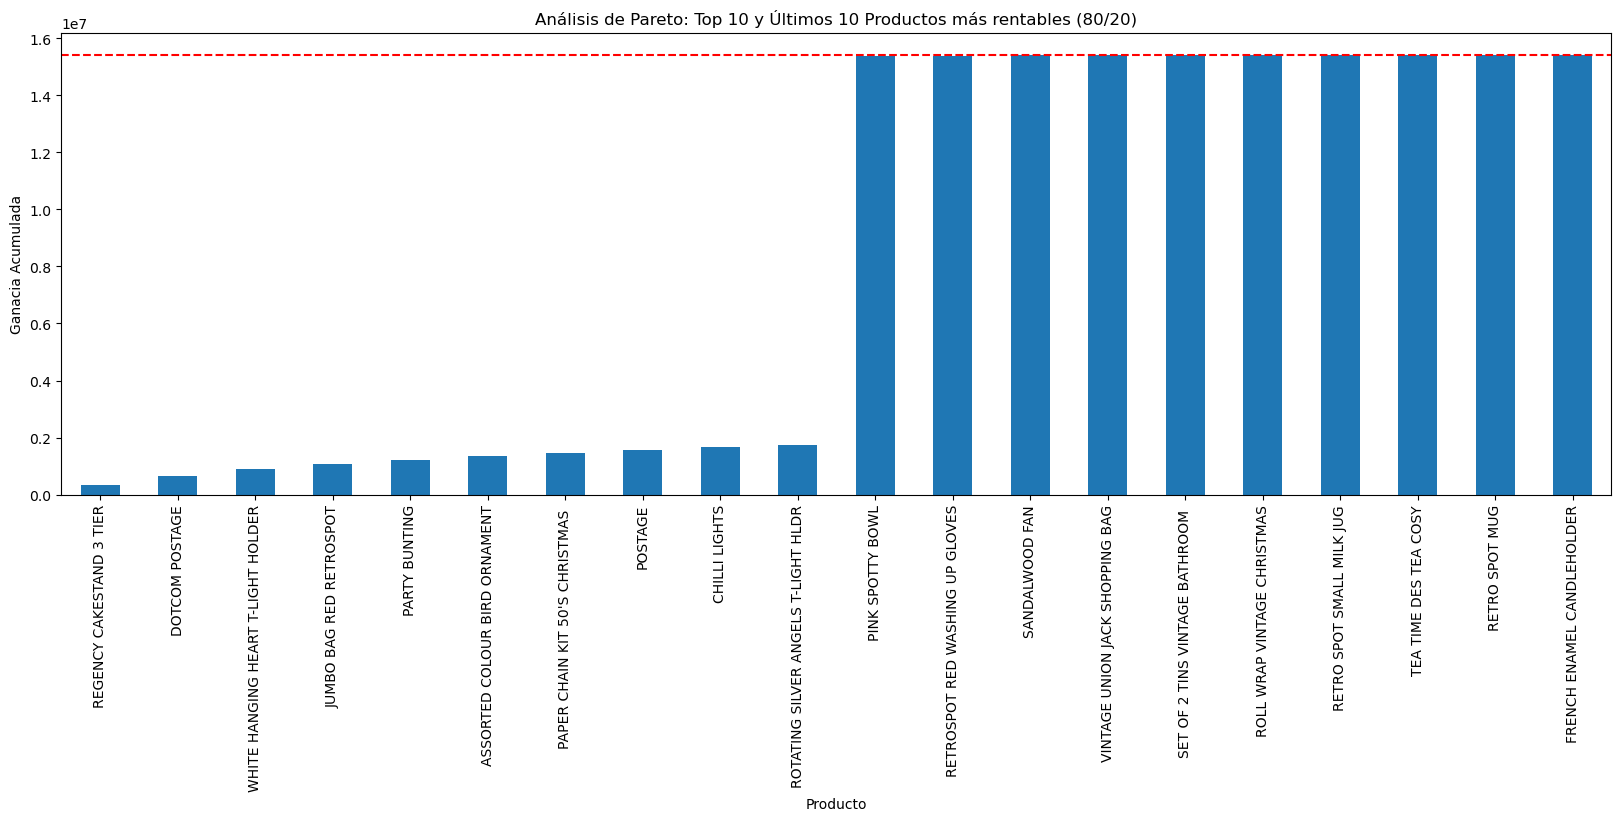

In [63]:
# Agrupar los productos por 'Descripción' y sumar la ganancia total, ordenando de mayor a menor
product_gains = df.groupby('Description')['Ganacia'].sum().sort_values(ascending=False)
pareto_threshold = product_gains.sum() * 0.8

# Calcular la suma acumulada
cumulative_sum = product_gains.cumsum()

# Seleccionar los productos que cumplen con el análisis de Pareto (80/20)
pareto_products = cumulative_sum[cumulative_sum <= pareto_threshold]

# Seleccionar los 10 primeros y 10 últimos
pareto_top_bottom = pd.concat([pareto_products.head(10), pareto_products.tail(10)])

# Graficar
plt.figure(figsize=(20, 6))
pareto_top_bottom.plot(kind='bar')
plt.axhline(y=pareto_threshold, color='r', linestyle='--')
plt.title('Análisis de Pareto: Top 10 y Últimos 10 Productos más rentables (80/20)')
plt.xlabel('Producto')
plt.ylabel('Ganacia Acumulada')
plt.show()


In [64]:
import seaborn as sns

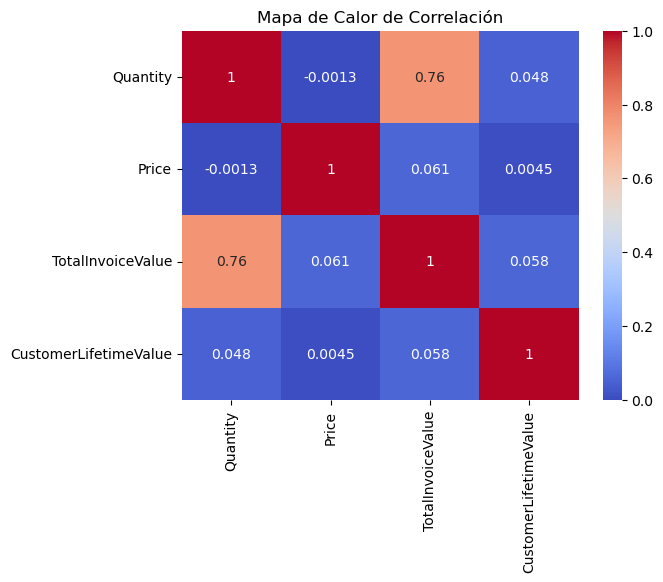

In [65]:
correlation_matrix = df[['Quantity', 'Price', 'TotalInvoiceValue', 'CustomerLifetimeValue']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')
plt.show()

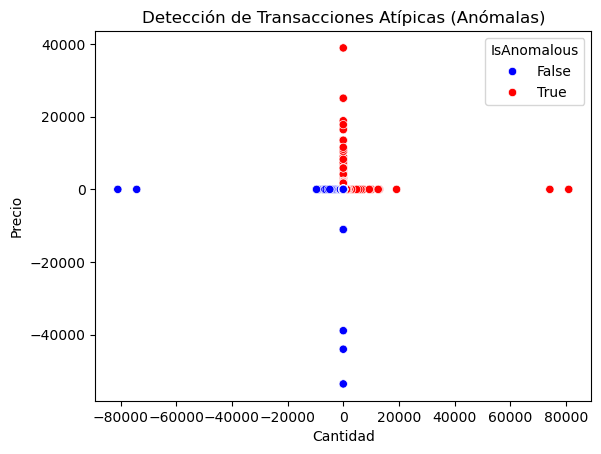

In [66]:
sns.scatterplot(x='Quantity', y='Price', hue='IsAnomalous', data=df, palette={True: 'red', False: 'blue'})
plt.title('Detección de Transacciones Atípicas (Anómalas)')
plt.xlabel('Cantidad')
plt.ylabel('Precio')
plt.show()

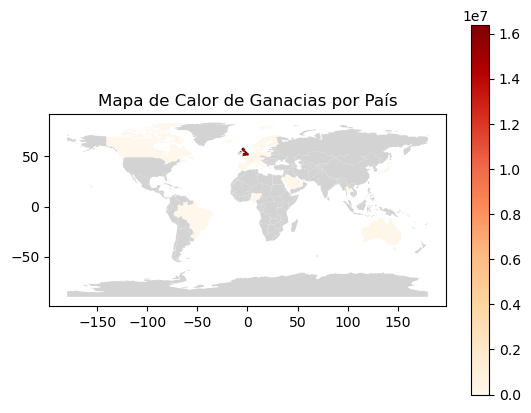

In [67]:

import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Mergear con tu DataFrame df
country_gains = df.groupby('Country')['Ganacia'].sum().reset_index()
world = world.merge(country_gains, how='left', left_on='name', right_on='Country')

world.plot(column='Ganacia', cmap='OrRd', legend=True, missing_kwds={"color": "lightgrey"})
plt.title('Mapa de Calor de Ganacias por País')
plt.show()

## Features Importance

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [69]:
# Definir las características (X) y la variable objetivo (y)
X = df[['Quantity', 'Price', 'Year', 'Month', 'Day', 'Hour',
        'DayOfWeek', 'IsWeekend', 'PurchaseFrequency', 
        'CustomerLifetimeValue', 'TotalQuantity', 'AvgPricePerTransaction',
        'IsAnomalous', 'CustomerMonthlyGain']]  # Características seleccionadas
y = df['TotalInvoiceValue']  # Ventas totales como variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [70]:
# Entrenar el modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [71]:
# Obtener la importancia de las características
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)


In [72]:
# Mostrar las características más importantes
print(feature_importances)

                          Importance
Quantity                7.309136e-01
AvgPricePerTransaction  1.210650e-01
Price                   9.091136e-02
TotalQuantity           2.769403e-02
Hour                    7.337845e-03
CustomerLifetimeValue   4.995547e-03
Month                   4.357852e-03
DayOfWeek               4.135327e-03
PurchaseFrequency       4.034610e-03
CustomerMonthlyGain     2.349787e-03
Day                     1.830761e-03
IsAnomalous             2.291045e-04
Year                    1.450874e-04
IsWeekend               1.384708e-07


## Prediction

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [74]:
# Inicializar el vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Convertir la columna de descripciones en una matriz TF-IDF
X = vectorizer.fit_transform(df['Description'])

In [75]:
# Definir el número de clusters (categorías) que deseas
num_clusters = 5

# Aplicar K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

In [76]:
# Ver el dataframe con las categorías asignadas
print(df)

        Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
1067366  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                              POSTAGE         1   

                InvoiceDate  Price  Customer ID         Country  Year  Month  \
0      

In [77]:
df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Year', 'Month', 'Day', 'Hour',
       'DayOfWeek', 'IsWeekend', 'Ganacia', 'Season', 'PurchaseFrequency',
       'CustomerLifetimeValue', 'TotalQuantity', 'AvgPricePerTransaction',
       'IsAnomalous', 'TotalInvoiceValue', 'CustomerMonthlyGain', 'Cluster'],
      dtype='object')

<Axes: xlabel='Cluster', ylabel='Ganacia'>

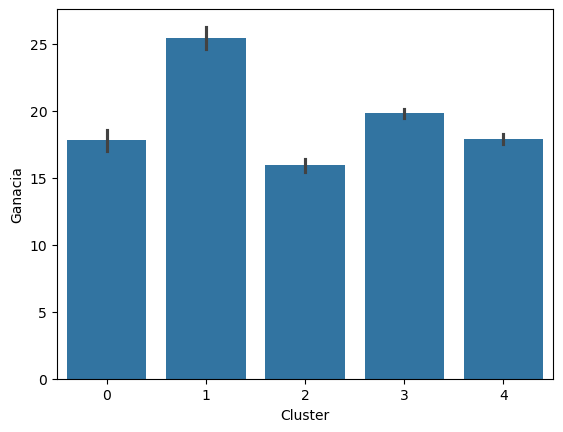

In [78]:
sns.barplot(df, x="Cluster",y="Ganacia")

In [79]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [80]:
# Limpiar las descripciones: convertir a minúsculas y eliminar caracteres especiales
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)  # Eliminar caracteres especiales
    return texto

In [81]:
df['descripcion_limpia'] = df['Description'].apply(limpiar_texto)

In [82]:
from collections import Counter

# Unir todas las descripciones en un solo string
texto_completo = ' '.join(df['descripcion_limpia'])

# Crear una lista de palabras, excluyendo las stopwords
palabras = [palabra for palabra in texto_completo.split() if palabra not in ENGLISH_STOP_WORDS]

# Contar la frecuencia de cada palabra
contador_palabras = Counter(palabras)

# Mostrar las 10 palabras más comunes
print(contador_palabras.most_common(10))


[('set', 115418), ('bag', 92821), ('red', 90651), ('heart', 78906), ('pink', 63932), ('retrospot', 58811), ('vintage', 55772), ('design', 54346), ('box', 51027), ('white', 48620)]


In [85]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

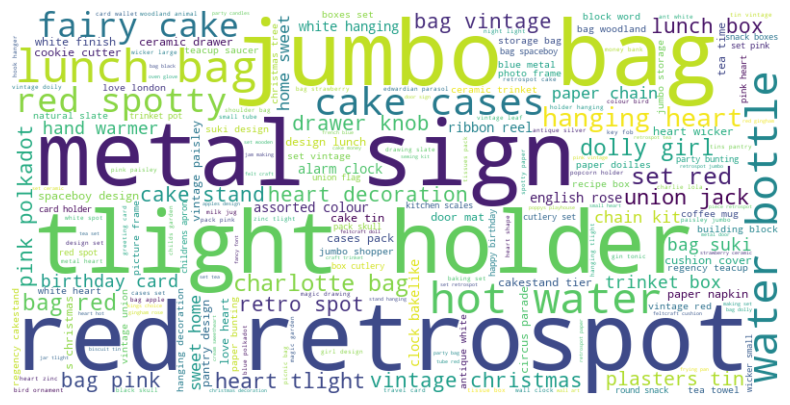

In [86]:
# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()